In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import os
import random

### Seed per riproducibilità

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(0)


In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## CIFAR-10

IL dataset CIFAR-10 contiene 60000 32x32 immagini RGB in 10 classi (6000 immagini per classe). Ci sono 50000 immagini nel training set e 10000 immagini nel test set.

Classi:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
#download train e test set

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:18<00:00, 9031808.84it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
#cosa abbiamo in ogni elemento del trainset?
trainset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [8]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [9]:
# funzione per convertire un'immagine da tensore ad un formato visualizzabile

def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


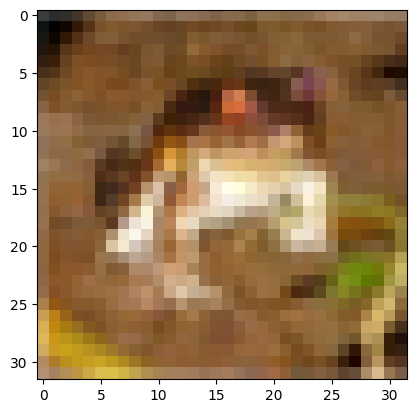

In [10]:
image = back_to_image(trainset[0][0])
plt.imshow(image)
plt.show()

In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
classes[int(trainset[0][1])]

'frog'

In [13]:
iteration = 0

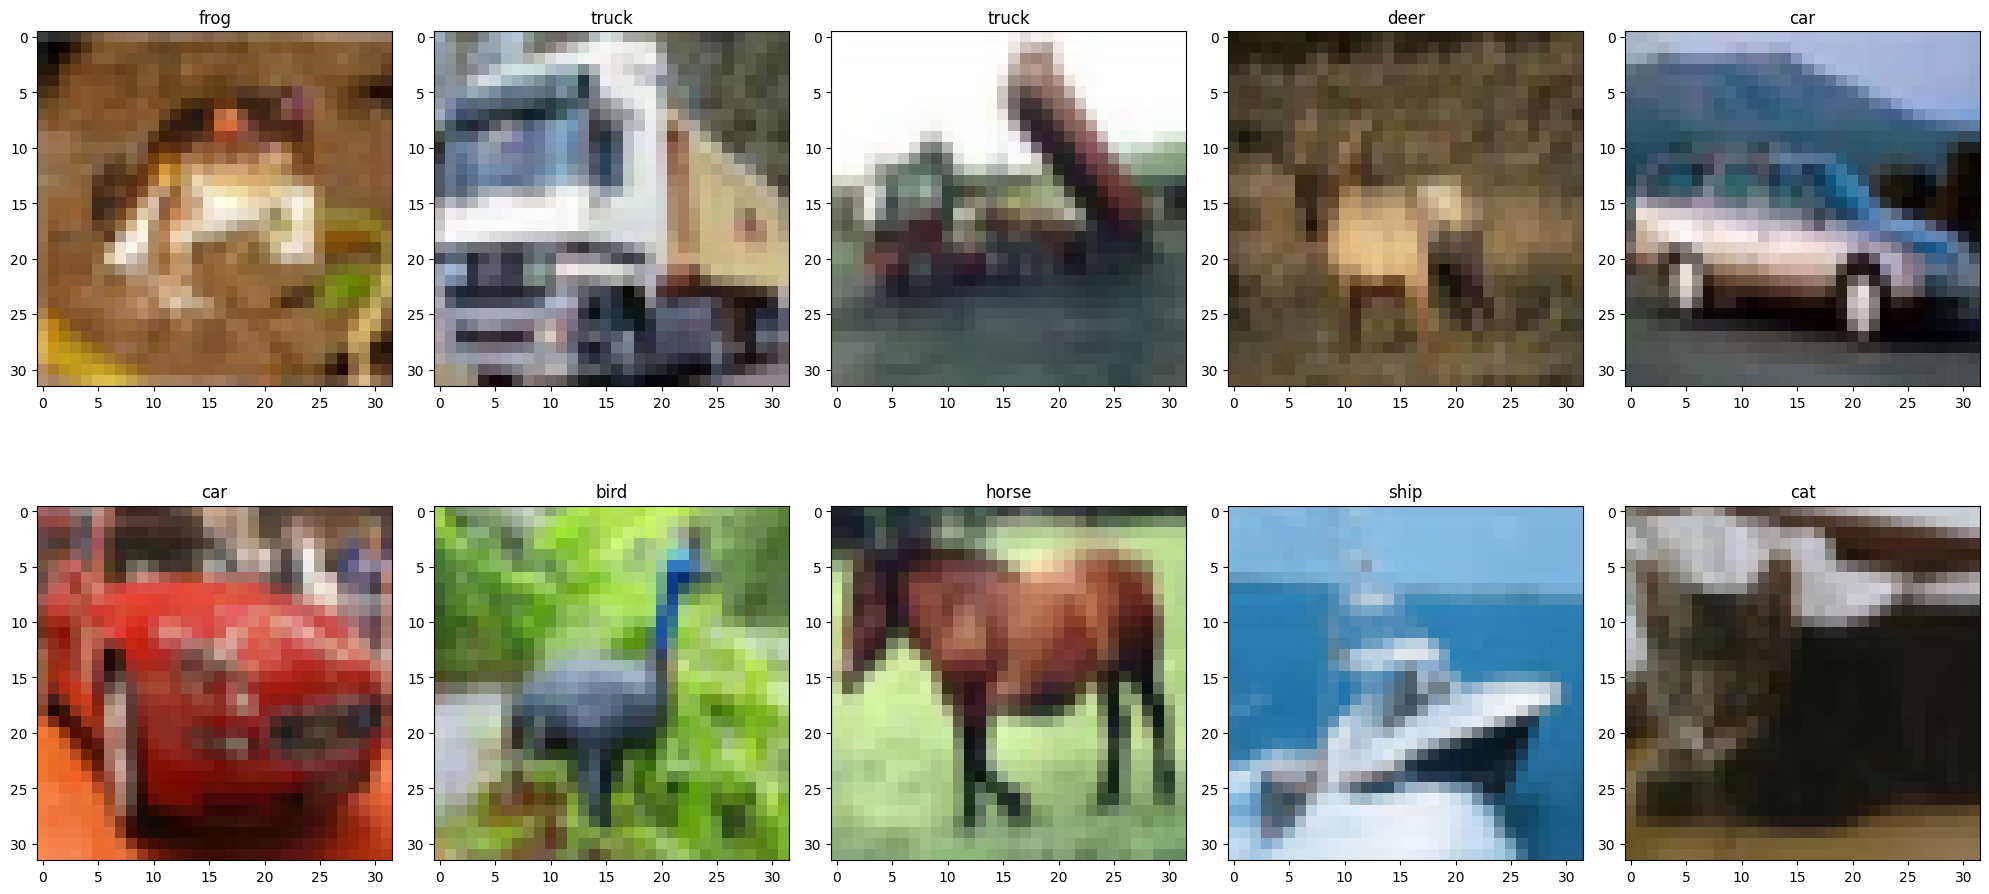

In [14]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

In [15]:
#carica in un dataloader

batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

## Convolutional Neural Network

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Parametri = 5*5*3 = 75 + 1 = 76 * 6 = 456
        self.pool = nn.MaxPool2d(2)      # Parametri = 0
        self.conv2 = nn.Conv2d(6, 16, 5) # Parametri = 5 * 5 * 6 = 150 + 1 = 151 * 16 = 2416


        self.fc1 = nn.Linear(400, 120) # Parametri = 400 + 1 = 401 * 120 = 48 120
        self.fc2 = nn.Linear(120, 84)  # Parametri = 120 + 1 = 121 * 84 = 10 164
        self.fc3 = nn.Linear(84, 10)   # Parametri = 84 + 1 = 85 * 10 = 850

    def forward(self, x):   #Input shape = N, 3, 32, 32
        x = self.conv1(x)   #Output shape = [N,6,28,28]
        x = F.relu(x)
        x = self.pool(x)    #Output shape = [N,6,14,14]

        x = self.conv2(x)   #Output shape = [N,16,10,10]
        x = F.relu(x)
        x = self.pool(x)    #Output shape = [N,16,5,5]

        x = torch.flatten(x, 1) # flatten su tutte le dimensioni  [N, 16*5*5] = [N,400]

        x = self.fc1(x) #Output shape = [N,120]
        x = F.relu(x)
        x = self.fc2(x) #Output shape = [N,84]
        x = F.relu(x)
        x = self.fc3(x) #Output shape = [N,10]

        return x

### Dimensione in input/output
Input: $N$, $C_{in}$, H, W  \\
Layer Convoluzionali: $[N, n\_filters, H- (Kernel\_size -1), W-(Kernel\_size -1)]$ \\
Max Pool 2d: Output: $[N, C_{in}, \frac{H}{2}, \frac{W}{2}]$

### Parameteri

Layer Convoluzionali: $(((Kernel_{w} * Kernel_{h})*n_{canali})+1)*n_{filtri}$ \\
Layer lineari : $(input + 1) * output$ \\
Max Pool 2d: 0


In [17]:
net = Net().to(device)

In [18]:
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


## Baseline

In [19]:
# conta le prediction corrette
correct_pred = 0
total_pred = 0
net.eval()
# non serve calcolare il gradiente
with torch.no_grad():
    for data in testloader:
        images, labels = list(map(lambda x: x.to(device), data)) #[32, 3, 32, 32], [32, 10]
        outputs = net(images) #[32, 10]
        _, predictions = torch.max(outputs, 1) #[32 ,1] [32, 1]
        # collezioniamo le prediction
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1
            total_pred += 1


accuracy = 100 * correct_pred / total_pred
print(f'Accuracy : {accuracy:.1f} %')

Accuracy : 10.1 %


## Training della CNN

In [ ]:
net.train()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
for epoch in range(10):  # ripeti il training per 10 epoche

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # dal Dataloader estrai un batch
        inputs, labels = list(map(lambda x: x.to(device), data)) #[32 , 3, 32, 32], [32, 10]

        # resetta i gradienti dell'optimizer
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) #[32 , 10]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # Scrivi il log ogni 500 batch
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Fine del Training')

In [ ]:
# conta le prediction corrette
correct_pred = 0
total_pred = 0
net.eval()
# non serve calcolare il gradiente
with torch.no_grad():
    for data in testloader:
        images, labels = list(map(lambda x: x.to(device), data))
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collezioniamo le prediction
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1
            total_pred += 1


accuracy = 100 * correct_pred / total_pred
print(f'Accuracy : {accuracy:.1f} %')